## Dependency Installation

In [40]:
!pip install pandas matplotlib seaborn scikit-learn

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from concurrent.futures import ThreadPoolExecutor

## Uploading the CSV File
Uploading the file containing our dataset and evaluation data

In [ ]:
from google.colab import files
uploaded_file = files.upload()

## Specifying a target and doing the 70/30 Test Split
1. Target# is Specified based on this:

| Target | Roll No. Ending |
| ------ | --------------- |
|   1    |       0,5       |
|   2    |       1,6       |
|   3    |       2,7       |
|   4    |       3,8       |
|   5    |       4,9       |

2. The filtered data gets divided into 70/30 ratio

In [42]:
df = pd.read_csv('data.csv')
# User input for last digits of roll numbers
user_patterns = input("Enter the last digits of roll numbers separated by commas: ").split(',')

# Assign targets based on the last digit modulo 5
df['Target'] = df['F1'].astype(str).apply(lambda x: f"Target{(int(x[-1]) % 5) + 1}")

# Filter the dataset to keep only the specified targets
df_filtered = df[df['Target'].isin([f"Target{(int(x[-1]) % 5) + 1}" for x in user_patterns])]

# Dynamic selection of columns for X (features) and y (target)
X_columns = [col for col in df_filtered.columns if 'Target' not in col]  # Exclude 'Target' from features
y_columns = [f"Target{(int(x[-1]) % 5) + 1}" for x in user_patterns]  # Extract the dynamic targets

X = df_filtered[X_columns]
y = df_filtered[y_columns]

# Display the filtered data as needed
print("Filtered X:", X.head())
print("Filtered y:", y.head())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Enter the last digits of roll numbers separated by commas: 7
Filtered X:       F1    F2    F3     F4      F5    F6     F7     F8   F9   F10      F11  \
7   81.7  2.71  81.0  10.67  103.17  46.5  0.121   99.1  353  1.92   97.876   
16  47.7  1.38  53.7  40.22  182.35  26.8  0.145  170.4  190  1.28   99.046   
21  39.7  1.64  70.2  27.48   77.90  35.5  0.345  344.2  249  0.69  103.117   
23  53.2  2.91  34.2  23.26  174.37  42.8  0.125  329.9  187  0.94   96.888   
29  31.7  2.63  74.9  35.20   95.33  27.3  0.131  145.1  197  1.40  101.222   

     F12   F13   F14   F15  
7   1.91   185  15.9   338  
16  1.77  6995  28.8   496  
21  1.67  8212  33.5   847  
23  2.12  4548  15.6  1364  
29  1.50  1601  25.4   724  
Filtered y:     Target3
7      72.5
16     66.2
21     76.0
23     69.3
29     69.1


In [54]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Ridge': Ridge(random_state=42),
    'SVR': SVR(),
    'ElasticNet': ElasticNet(random_state=42),
    'KNNRegressor': KNeighborsRegressor()
}

def train_and_evaluate(model_name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # For regression, we typically use mean squared error, R^2, etc.
    report = {
        'MSE': mean_squared_error(y_test, y_pred),
        'R^2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    return model_name, report

results = {}
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(train_and_evaluate, name, model): name for name, model in models.items()}
    for future in futures:
        model_name, report = future.result()
        results[model_name] = report

# Save the results as CSVs
for model_name, report in results.items():
    pd.DataFrame(report, index=[0]).to_csv(f'{model_name}_results.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


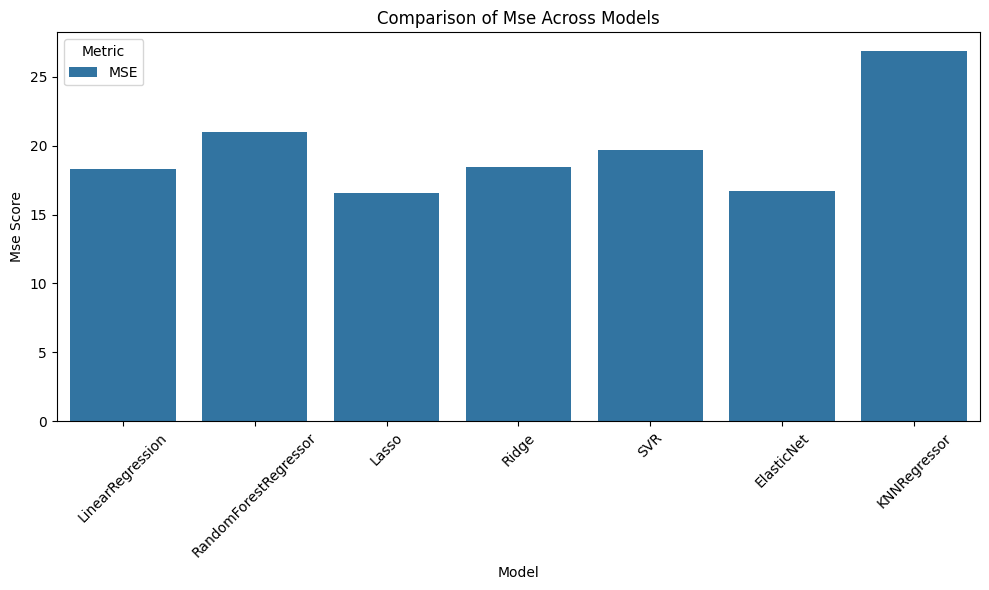

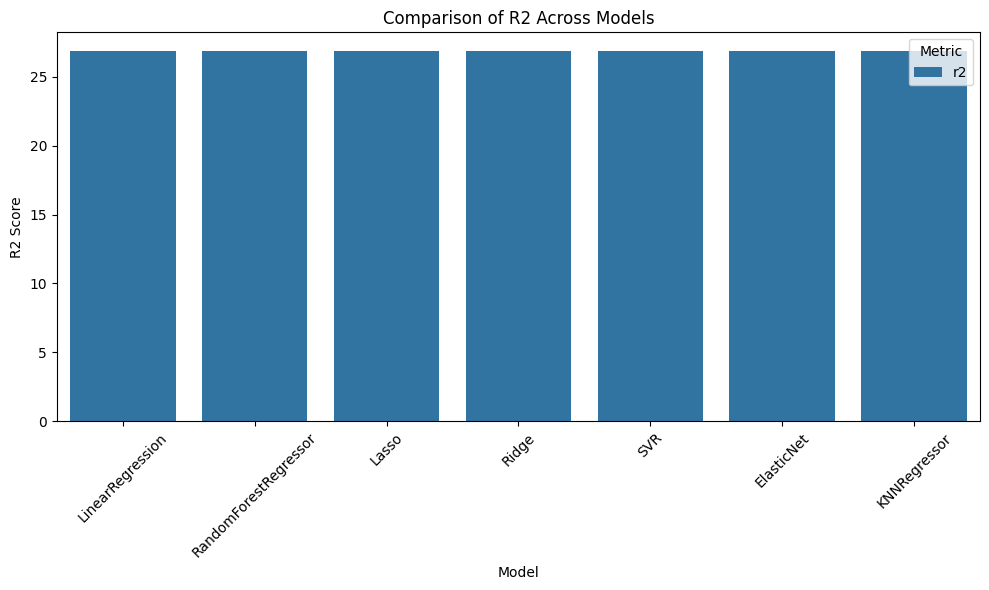

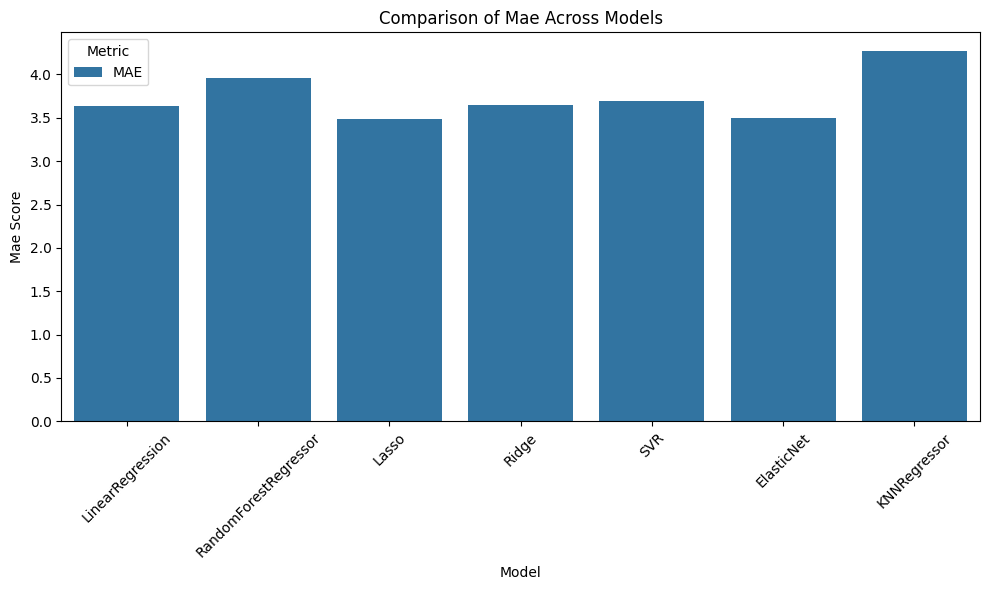

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Regression - MAE: 3.9604285714285727, R^2: -0.049736379394776264


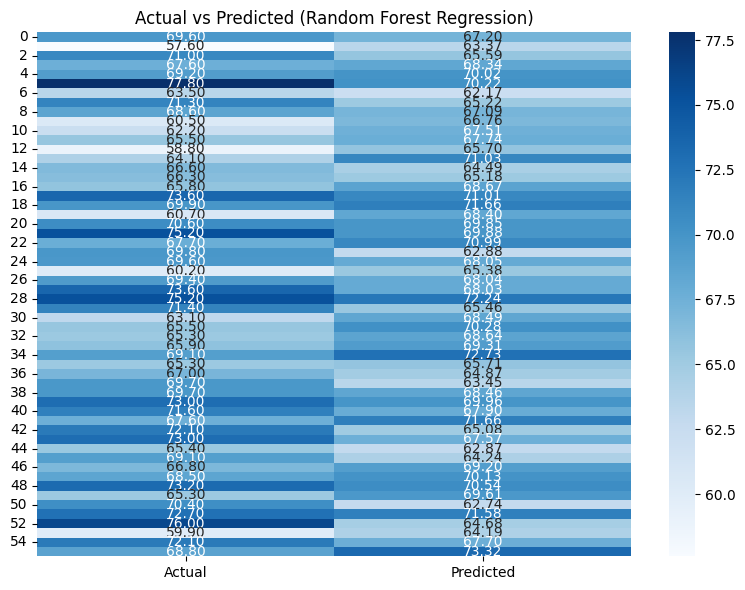

In [56]:
metrics = ['MSE', 'r2', 'MAE']
for metric in metrics:
    metric_data = []
    for model_name, report in results.items():
        if metric == 'MSE':
            avg_metric = report['MSE']
        elif metric == 'R2':
            avg_metric = report['R^2']
        elif metric == 'MAE':
            avg_metric = report['MAE']

        metric_data.append({'Model': model_name, 'Metric': metric, 'Score': avg_metric})

    metric_df = pd.DataFrame(metric_data)

    # Plot metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(data=metric_df, x='Model', y='Score', hue='Metric')
    plt.title(f'Comparison of {metric.capitalize()} Across Models')
    plt.ylabel(f'{metric.capitalize()} Score')
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

rf_model = models['RandomForestRegressor']
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Ensure y_test and y_pred_rf are 1-dimensional
y_test = y_test.flatten()  # Ensure y_test is 1-dimensional
y_pred_rf = y_pred_rf.flatten()  # Ensure y_pred_rf is 1-dimensional

# Calculate and print regression metrics for RandomForest
mae = mean_absolute_error(y_test, y_pred_rf)  # Mean Absolute Error
r2 = r2_score(y_test, y_pred_rf)              # R-squared
print(f"Random Forest Regression - MAE: {mae}, R^2: {r2}")

# Heatmap for actual vs predicted values
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf}), annot=True, fmt='.2f', cmap='Blues')
plt.title('Actual vs Predicted (Random Forest Regression)')
plt.tight_layout()
plt.show()